# Bike Accident Hotspot Prediction Analysis

This notebook demonstrates the use of machine learning clustering techniques to predict future bike accident hotspots in Amsterdam. We'll use the `BikeAccidentHotspotPredictor` class to:

1. **Load and preprocess** multiple datasets (coordinates, weather, injury data)
2. **Apply HDBSCAN clustering** to identify current accident hotspots
3. **Analyze patterns** in weather, injury severity, and temporal data
4. **Predict future hotspots** based on various weather scenarios
5. **Visualize results** on interactive maps

## Table of Contents
- [Setup and Imports](#setup)
- [Data Loading and Exploration](#data-loading)
- [Hotspot Clustering Analysis](#clustering)
- [Weather Pattern Analysis](#weather)
- [Injury Severity Analysis](#injury)
- [Future Hotspot Predictions](#predictions)
- [Interactive Visualizations](#visualizations)
- [Results Summary](#summary)

## Setup and Imports {#setup}

First, let's import all necessary libraries and our custom prediction class.

In [5]:
# Standard library imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path to import our custom module
sys.path.append('..')

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
import hdbscan

# Import our custom prediction class
from predict_future_hotspots import BikeAccidentHotspotPredictor

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

All libraries imported successfully!
Working directory: /Users/volkan.coskun/esra/data/Week_9/Prediction_Bike_Accident/notebook


## Data Loading and Exploration {#data-loading}

Let's initialize our predictor and load the three main datasets:
- **Coordinate data** (`df_ams_cc.csv`): Accident locations with lat/lon coordinates
- **Weather data** (`yearly_wea.csv`): Annual weather patterns
- **Injury data** (`gdf_joined.csv`): Injury severity and weekday patterns

In [7]:
# Initialize the predictor
predictor = BikeAccidentHotspotPredictor()

# Load all datasets
predictor.load_data()

print("\n Dataset Overview:")
print(f"Coordinate data shape: {predictor.df_coordinates.shape}")
print(f"Weather data shape: {predictor.df_weather.shape}")
print(f"Injury/Weekday data shape: {predictor.df_injury_weekday.shape}")

Loading datasets...
Coordinates data shape: (29765, 18)
Weather data shape: (7, 7)
Injury/Weekday data shape: (1803, 24)

 Dataset Overview:
Coordinate data shape: (29765, 18)
Weather data shape: (7, 7)
Injury/Weekday data shape: (1803, 24)


### Explore the Coordinate Data

In [9]:
# Display basic info about coordinate data
print(" Coordinate Data Sample:")
display(predictor.df_coordinates.head())

print("\n Coordinate Data Info:")
print(predictor.df_coordinates.info())

print("\n Missing Values:")
print(predictor.df_coordinates.isnull().sum())

 Coordinate Data Sample:


,Unnamed: 0,participant_id,accident_id,accident_year,roadsegment_id,municipality,roadsegment_id.1,segment_startdate,segment_enddate,roadnumber,streetname,neighborhood,municipality.1,shape,rd_x,rd_y,longitude,latitude
0,0,NaN,20140010399,2014.0,244380021.0,Amsterdam,244380021.0,2020-12-01T00:00:00,2024-05-31T00:00:00,NaN,Klaprozenweg,Amsterdam,Amsterdam,LINESTRING (122469.24489999935 490087.15410000...,122469.2449,490087.1541,4.909244,52.397660
1,1,NaN,20140011623,2014.0,242372014.0,Amsterdam,242372014.0,2020-12-01T00:00:00,2024-05-31T00:00:00,NaN,Vijzelstraat,Amsterdam,Amsterdam,LINESTRING (121256.4354000017 486163.425799999...,121256.4354,486163.4258,4.891820,52.362323
2,2,NaN,20140011930,2014.0,253372001.0,Amsterdam,253372001.0,2021-10-01T00:00:00,NaN,010,Ringweg-Oost,Amsterdam,Amsterdam,"LINESTRING (126588.02679999918 486233.7511, 12...",126588.0268,486233.7511,4.970084,52.363257
3,3,NaN,20140014189,2014.0,241378037.0,Amsterdam,241378037.0,2020-05-01T00:00:00,2021-12-31T00:00:00,NaN,Tasmanstraat,Amsterdam,Amsterdam,LINESTRING (120583.93600000069 489379.40599999...,120583.9360,489379.4060,4.881618,52.391185
4,4,NaN,20140014197,2014.0,233376127.0,Amsterdam,233376127.0,2020-12-01T00:00:00,2024-05-31T00:00:00,NaN,Burg De Vlugtlaan,Amsterdam,Amsterdam,LINESTRING (116948.81799999997 488192.20080000...,116948.8180,488192.2008,4.828353,52.380275



 Coordinate Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29765 entries, 0 to 29764
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         29765 non-null  int64  
 1   participant_id     11 non-null     float64
 2   accident_id        29765 non-null  int64  
 3   accident_year      29765 non-null  float64
 4   roadsegment_id     29765 non-null  float64
 5   municipality       29765 non-null  object 
 6   roadsegment_id.1   29765 non-null  float64
 7   segment_startdate  29765 non-null  object 
 8   segment_enddate    20591 non-null  object 
 9   roadnumber         11914 non-null  object 
 10  streetname         29765 non-null  object 
 11  neighborhood       29765 non-null  object 
 12  municipality.1     29765 non-null  object 
 13  shape              29765 non-null  object 
 14  rd_x               29765 non-null  float64
 15  rd_y               29765 non-null  float64
 16

### Explore the Weather Data

In [11]:
# Define the color theme
colors = {
    'primary_blue': '#A8CEF1',
    'secondary_blue': '#4B9FE1',
    'background': '#F5F9FF',
    'grid': '#E5E5E5',
    'text': '#2F3545'
}

Weather Data:


,Unnamed: 0,accident_year,total_accidents,temp_C,precip_mm,wind_avg_ms,visibility_range
0,0,2017.0,2384,11.116712,2.555068,4.806027,22541.643836
1,1,2018.0,2685,11.505753,1.516986,4.801644,22850.410959
2,2,2019.0,3961,11.324932,2.349315,4.885205,22981.643836
3,3,2020.0,3052,11.810656,2.367486,5.197268,23376.775956
4,4,2021.0,3599,10.611507,2.346575,4.543288,23972.328767
5,5,2022.0,3754,11.858356,2.235616,4.732603,25016.712329
6,6,2023.0,4660,11.980548,2.985753,5.212055,22463.835616


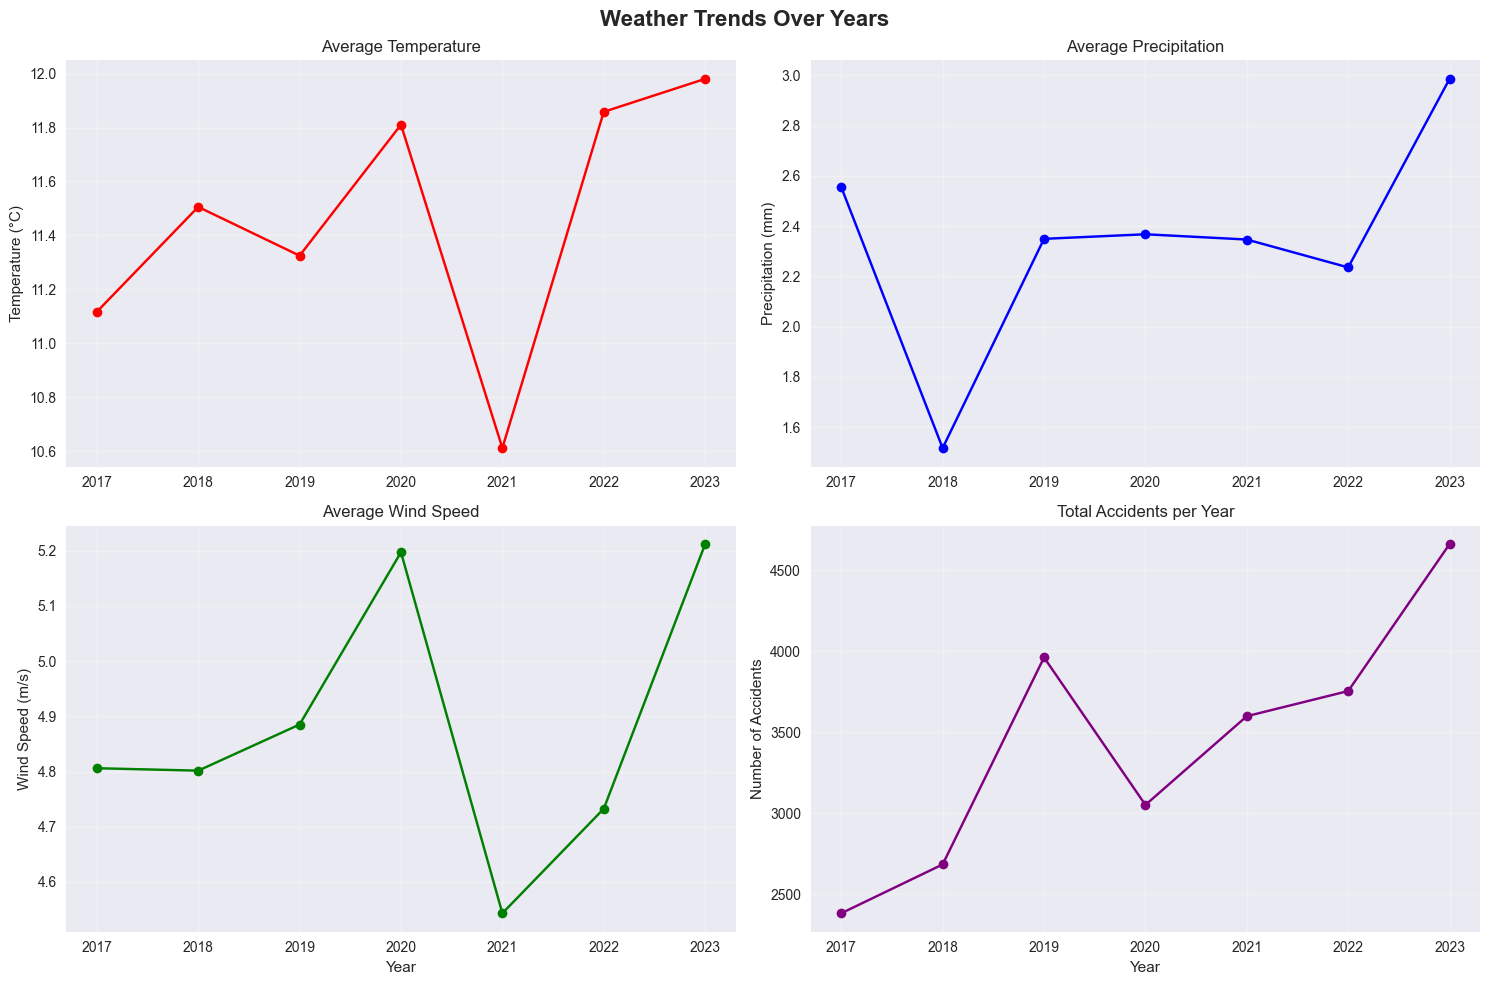

In [12]:
# Display weather data
print("Weather Data:")
display(predictor.df_weather)

# Plot weather trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Weather Trends Over Years', fontsize=16, fontweight='bold')

# Temperature trend
axes[0,0].plot(predictor.df_weather['accident_year'], predictor.df_weather['temp_C'], 'o-', color='red')
axes[0,0].set_title('Average Temperature')
axes[0,0].set_ylabel('Temperature (°C)')
axes[0,0].grid(True, alpha=0.3)

# Precipitation trend
axes[0,1].plot(predictor.df_weather['accident_year'], predictor.df_weather['precip_mm'], 'o-', color='blue')
axes[0,1].set_title('Average Precipitation')
axes[0,1].set_ylabel('Precipitation (mm)')
axes[0,1].grid(True, alpha=0.3)

# Wind speed trend
axes[1,0].plot(predictor.df_weather['accident_year'], predictor.df_weather['wind_avg_ms'], 'o-', color='green')
axes[1,0].set_title('Average Wind Speed')
axes[1,0].set_ylabel('Wind Speed (m/s)')
axes[1,0].set_xlabel('Year')
axes[1,0].grid(True, alpha=0.3)

# Total accidents trend
axes[1,1].plot(predictor.df_weather['accident_year'], predictor.df_weather['total_accidents'], 'o-', color='purple')
axes[1,1].set_title('Total Accidents per Year')
axes[1,1].set_ylabel('Number of Accidents')
axes[1,1].set_xlabel('Year')
axes[1,1].grid(True, alpha=0.3)
plot_path2='../presentation/total_acc_per_year.png'
plt.tight_layout()
plt.savefig(plot_path2, facecolor=colors['background'])
plt.show()

### Explore the Injury Data

In [14]:
# Display injury data sample
print(" Injury Data Sample:")
display(predictor.df_injury_weekday.head())

print("\n Injury Data Statistics:")
injury_cols = ['total_accidents', 'injury_accidents', 'fatal_accidents', 'damage_only_accidents']
if all(col in predictor.df_injury_weekday.columns for col in injury_cols):
    display(predictor.df_injury_weekday[injury_cols].describe())

 Injury Data Sample:


,Unnamed: 0,accident_id,total_accidents,fatal_accidents,injury_accidents,damage_only_accidents,geometry_wkt,geometry,centroid,index_right,...,weekday_2020,weekday_2019,weekday_2018,weekday_2017,location_code,wkt_lng_lat,wkt_lat_lng,longitude,latitude,distance_m
0,0,1,1,0,1,0,POLYGON ((179046.73279999942 309408.8781999983...,"POLYGON ((5.728085069118202 50.77410669272724,...",POINT (179040.2349995231 309458.4569960681),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,169007.617336
1,1,2,1,0,0,1,"POLYGON ((177255.8396999985 310240.2259999998,...","POLYGON ((5.702748546852566 50.78165155046857,...",POINT (177249.3590014013 310289.8069981025),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,167790.579361
2,2,3,1,0,0,1,POLYGON ((178901.10350000113 311532.4411999993...,"POLYGON ((5.72616005741394 50.79320068551851, ...",POINT (178894.6069976456 311582.0199980425),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,166908.586421
3,3,4,1,0,1,0,POLYGON ((178656.49430000037 313910.4211000018...,"POLYGON ((5.722845762480663 50.8145856106313, ...",POINT (178649.9999999999 313960),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,164539.720943
4,4,5,2,0,2,0,"POLYGON ((176617.4726999998 313949.6506000012,...","POLYGON ((5.693918115118937 50.81501866838283,...",POINT (176610.9979999998 313999.232),131,...,633,0,830,0,VRA01_0155,POINT(5.164806 52.252951),POINT(52.252951 5.164806),5.164806,52.252951,164032.344449



 Injury Data Statistics:


,total_accidents,injury_accidents,fatal_accidents,damage_only_accidents
count,1803.000000,1803.000000,1803.000000,1803.000000
mean,1.500277,0.810316,0.019967,0.669994
std,1.247584,0.912099,0.147644,0.873410
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000
75%,2.000000,1.000000,0.000000,1.000000
max,14.000000,11.000000,2.000000,8.000000


## Hotspot Clustering Analysis {#clustering}

Now let's preprocess the coordinate data and apply HDBSCAN clustering to identify accident hotspots.

In [16]:
# Preprocess coordinate data for clustering
predictor.preprocess_coordinate_data()

print(f" Preprocessed data shape: {predictor.clustering_features.shape}")
print(f" Clean coordinate data shape: {predictor.coord_data_clean.shape}")

Preprocessing coordinate data...
Cleaned coordinate data shape: (29763, 18)
 Preprocessed data shape: (29763, 5)
 Clean coordinate data shape: (29763, 18)


In [17]:
# Apply HDBSCAN clustering
predictor.apply_hdbscan_clustering(min_cluster_size=50, min_samples=10)

# Display clustering results
cluster_counts = predictor.coord_data_clean['cluster'].value_counts().sort_index()
print(f"\n Clustering Results:")
print(f"Number of clusters found: {len(predictor.hotspot_clusters)}")
print(f"Noise points (cluster -1): {cluster_counts.get(-1, 0)}")
print(f"\nCluster sizes:")
for cluster_id in predictor.hotspot_clusters[:10]:  # Show top 10
    print(f"  Cluster {cluster_id}: {cluster_counts[cluster_id]} accidents")

Applying HDBSCAN clustering...
Found 170 hotspot clusters
Noise points: 9986
Silhouette Score: 0.486

 Clustering Results:
Number of clusters found: 170
Noise points (cluster -1): 9986

Cluster sizes:
  Cluster 0: 142 accidents
  Cluster 1: 404 accidents
  Cluster 2: 144 accidents
  Cluster 3: 225 accidents
  Cluster 4: 91 accidents
  Cluster 5: 190 accidents
  Cluster 6: 186 accidents
  Cluster 7: 213 accidents
  Cluster 8: 298 accidents
  Cluster 9: 153 accidents


### Visualize Cluster Distribution

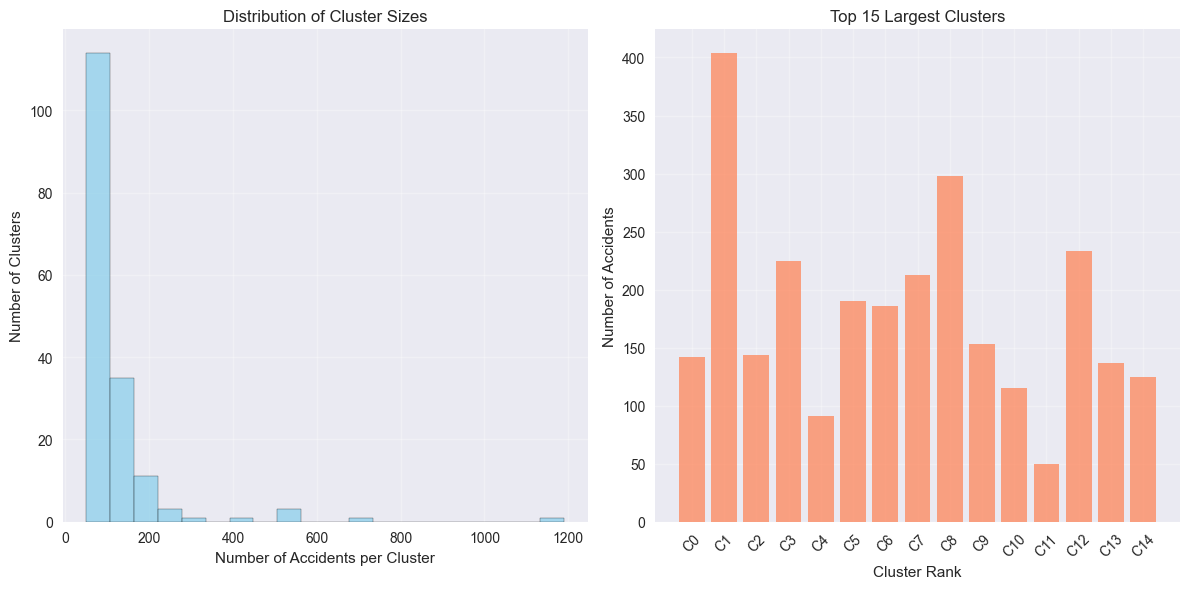

In [59]:
# Plot cluster size distribution
plt.figure(figsize=(12, 6))

# Exclude noise points for visualization
cluster_sizes = cluster_counts[cluster_counts.index != -1]

plt.subplot(1, 2, 1)
plt.hist(cluster_sizes.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Number of Accidents per Cluster')
plt.ylabel('Number of Clusters')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
top_clusters = cluster_sizes.head(15)
plt.bar(range(len(top_clusters)), top_clusters.values, color='coral', alpha=0.7)
plt.title('Top 15 Largest Clusters')
plt.xlabel('Cluster Rank')
plt.ylabel('Number of Accidents')
plt.xticks(range(len(top_clusters)), [f'C{i}' for i in top_clusters.index])
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path1='../presentation/top_15_cluster.png'

plt.savefig(plot_path1, facecolor=colors['background'])

plt.show()

### Analyze Hotspot Characteristics

In [18]:
# Analyze hotspot characteristics
predictor.analyze_hotspot_characteristics()

print("\n🔍 Top 10 Hotspots by Accident Count:")
display(predictor.hotspot_analysis.head(10))

Analyzing hotspot characteristics...

Top 10 Hotspots by Accident Count:
     cluster_id  accident_count  center_lat  center_lon  \
117         117            1189   52.366644    4.884808   
162         162             702   52.371939    4.866020   
151         151             534   52.371010    4.874055   
132         132             523   52.367065    4.885008   
105         105             510   52.366051    4.892941   
1             1             404   52.303393    4.967976   
8             8             298   52.308857    4.971623   
167         167             249   52.381113    4.842852   
12           12             233   52.310703    4.960736   
3             3             225   52.307002    4.958476   

                                           top_streets  
117  Ringweg-West (63), Ringweg-Zuid (41), Stadhoud...  
162  Ringweg-West (37), Haarlemmerweg (35), Kinkers...  
151  Ringweg-West (56), Marnixstraat (24), Nassauka...  
132  Stadhouderskade (37), Sarphatipark (35), Mar

,cluster_id,accident_count,center_lat,center_lon,lat_std,lon_std,year_range,avg_year,top_streets
117,117,1189,52.366644,4.884808,0.012518,0.026400,2022-2022,2022.0,"Ringweg-West (63), Ringweg-Zuid (41), Stadhoud..."
162,162,702,52.371939,4.866020,0.009243,0.021939,2021-2021,2021.0,"Ringweg-West (37), Haarlemmerweg (35), Kinkers..."
151,151,534,52.371010,4.874055,0.006131,0.019957,2017-2017,2017.0,"Ringweg-West (56), Marnixstraat (24), Nassauka..."
132,132,523,52.367065,4.885008,0.009017,0.013924,2015-2015,2015.0,"Stadhouderskade (37), Sarphatipark (35), Marni..."
105,105,510,52.366051,4.892941,0.011068,0.014551,2018-2018,2018.0,"Stadhouderskade (41), Haarlemmerweg (24), De R..."
1,1,404,52.303393,4.967976,0.013301,0.028392,2023-2023,2023.0,"Gaasperdammerweg (69), KP HOLENDRECHT (52), RY..."
8,8,298,52.308857,4.971623,0.010902,0.025603,2021-2021,2021.0,"Gaasperdammerweg (24), Bijlmerdreef (19), KP H..."
167,167,249,52.381113,4.842852,0.006584,0.005583,2023-2023,2023.0,"Ringweg-West (105), Haarlemmerweg (23), Bos en..."
12,12,233,52.310703,4.960736,0.009415,0.017371,2022-2022,2022.0,"Gaasperdammerweg (45), Bijlmerdreef (17), Gooi..."
3,3,225,52.307002,4.958476,0.013179,0.011713,2019-2019,2019.0,"Gooiseweg (25), RYKSWG (24), Bijlmerdreef (23)"


## Weather Pattern Analysis {#weather}

Let's analyze weather patterns to understand their impact on accident rates.

In [20]:
# Incorporate weather patterns
predictor.incorporate_weather_patterns()

print("\n🌦️ Weather Risk Analysis:")
display(predictor.weather_analysis[['accident_year', 'total_accidents', 'high_risk_weather', 'temp_C', 'precip_mm', 'wind_avg_ms']])

Analyzing weather patterns...
Weather Risk Analysis:
   accident_year  total_accidents  high_risk_weather     temp_C  precip_mm
0         2017.0             2384                  0  11.116712   2.555068
1         2018.0             2685                  0  11.505753   1.516986
2         2019.0             3961                  0  11.324932   2.349315
3         2020.0             3052                  0  11.810656   2.367486
4         2021.0             3599                  0  10.611507   2.346575
5         2022.0             3754                  0  11.858356   2.235616
6         2023.0             4660                  0  11.980548   2.985753

🌦️ Weather Risk Analysis:


,accident_year,total_accidents,high_risk_weather,temp_C,precip_mm,wind_avg_ms
0,2017.0,2384,0,11.116712,2.555068,4.806027
1,2018.0,2685,0,11.505753,1.516986,4.801644
2,2019.0,3961,0,11.324932,2.349315,4.885205
3,2020.0,3052,0,11.810656,2.367486,5.197268
4,2021.0,3599,0,10.611507,2.346575,4.543288
5,2022.0,3754,0,11.858356,2.235616,4.732603
6,2023.0,4660,0,11.980548,2.985753,5.212055


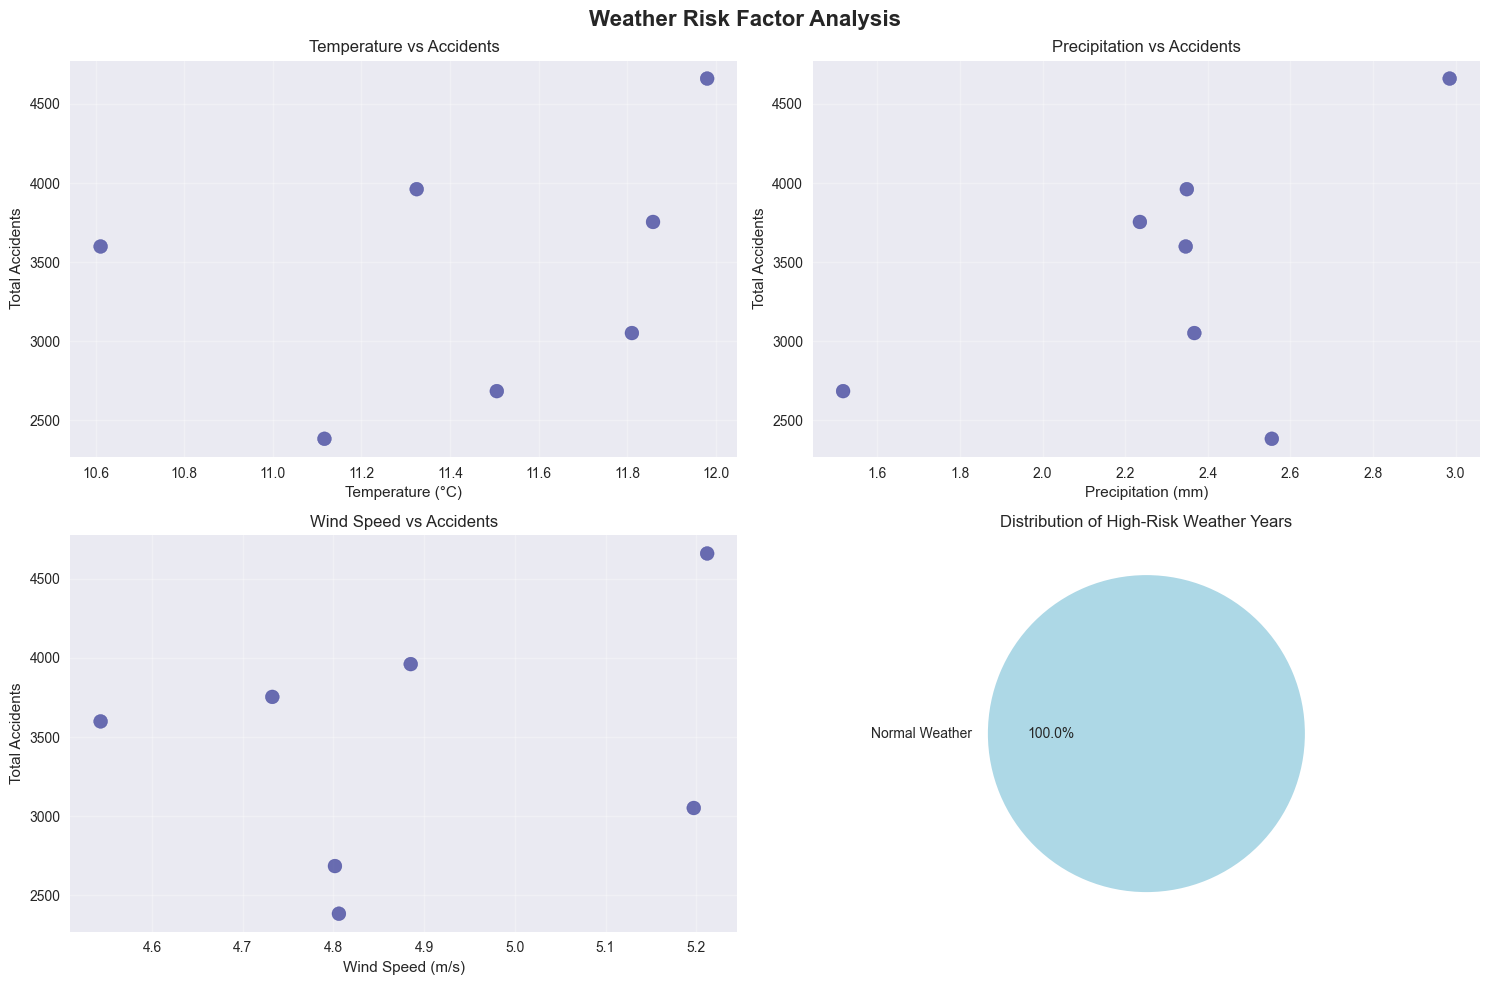

In [88]:
# Visualize weather risk factors
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Weather Risk Factor Analysis', fontsize=16, fontweight='bold')

weather_data = predictor.weather_analysis

# Temperature vs Accidents
axes[0,0].scatter(weather_data['temp_C'], weather_data['total_accidents'], 
                 c=weather_data['high_risk_weather'], cmap='RdYlBu_r', s=100, alpha=0.7)
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Total Accidents')
axes[0,0].set_title('Temperature vs Accidents')
axes[0,0].grid(True, alpha=0.3)

# Precipitation vs Accidents
axes[0,1].scatter(weather_data['precip_mm'], weather_data['total_accidents'], 
                 c=weather_data['high_risk_weather'], cmap='RdYlBu_r', s=100, alpha=0.7)
axes[0,1].set_xlabel('Precipitation (mm)')
axes[0,1].set_ylabel('Total Accidents')
axes[0,1].set_title('Precipitation vs Accidents')
axes[0,1].grid(True, alpha=0.3)

# Wind vs Accidents
axes[1,0].scatter(weather_data['wind_avg_ms'], weather_data['total_accidents'], 
                 c=weather_data['high_risk_weather'], cmap='RdYlBu_r', s=100, alpha=0.7)
axes[1,0].set_xlabel('Wind Speed (m/s)')
axes[1,0].set_ylabel('Total Accidents')
axes[1,0].set_title('Wind Speed vs Accidents')
axes[1,0].grid(True, alpha=0.3)


# High-risk weather years (automatically handles label count)
risk_counts = weather_data['high_risk_weather'].value_counts()
labels = ['Normal Weather' if val == 0 else 'High-Risk Weather' for val in risk_counts.index]
axes[1,1].pie(risk_counts.values, labels=labels, 
              autopct='%1.1f%%', colors=['lightblue', 'salmon'][:len(risk_counts)])
axes[1,1].set_title('Distribution of High-Risk Weather Years')

plot_path3='../presentation/weather_risk_fac.png'
plt.savefig(plot_path3, facecolor=colors['background'])
plt.tight_layout()
plt.show()

## Injury Severity Analysis {#injury}

Now let's analyze injury patterns and severity to identify high-risk locations.

In [25]:
# Incorporate injury and weekday patterns
predictor.incorporate_injury_weekday_patterns()

print("\n Injury Severity Analysis Summary:")
injury_data = predictor.injury_analysis

print(f"Total locations analyzed: {len(injury_data):,}")
print(f"High-risk locations: {injury_data['high_risk_location'].sum():,}")
print(f"Average injury rate: {injury_data['injury_rate'].mean():.3f}")
print(f"Locations with fatalities: {(injury_data['fatal_rate'] > 0).sum():,}")
print(f"Average severity score: {injury_data['severity_score'].mean():.3f}")

Analyzing injury severity and weekday patterns...
Injury Severity Analysis:
High injury rate locations: 34
Average injury rate: 0.544
Locations with fatalities: 34

 Injury Severity Analysis Summary:
Total locations analyzed: 1,803
High-risk locations: 34
Average injury rate: 0.544
Locations with fatalities: 34
Average severity score: 1.576


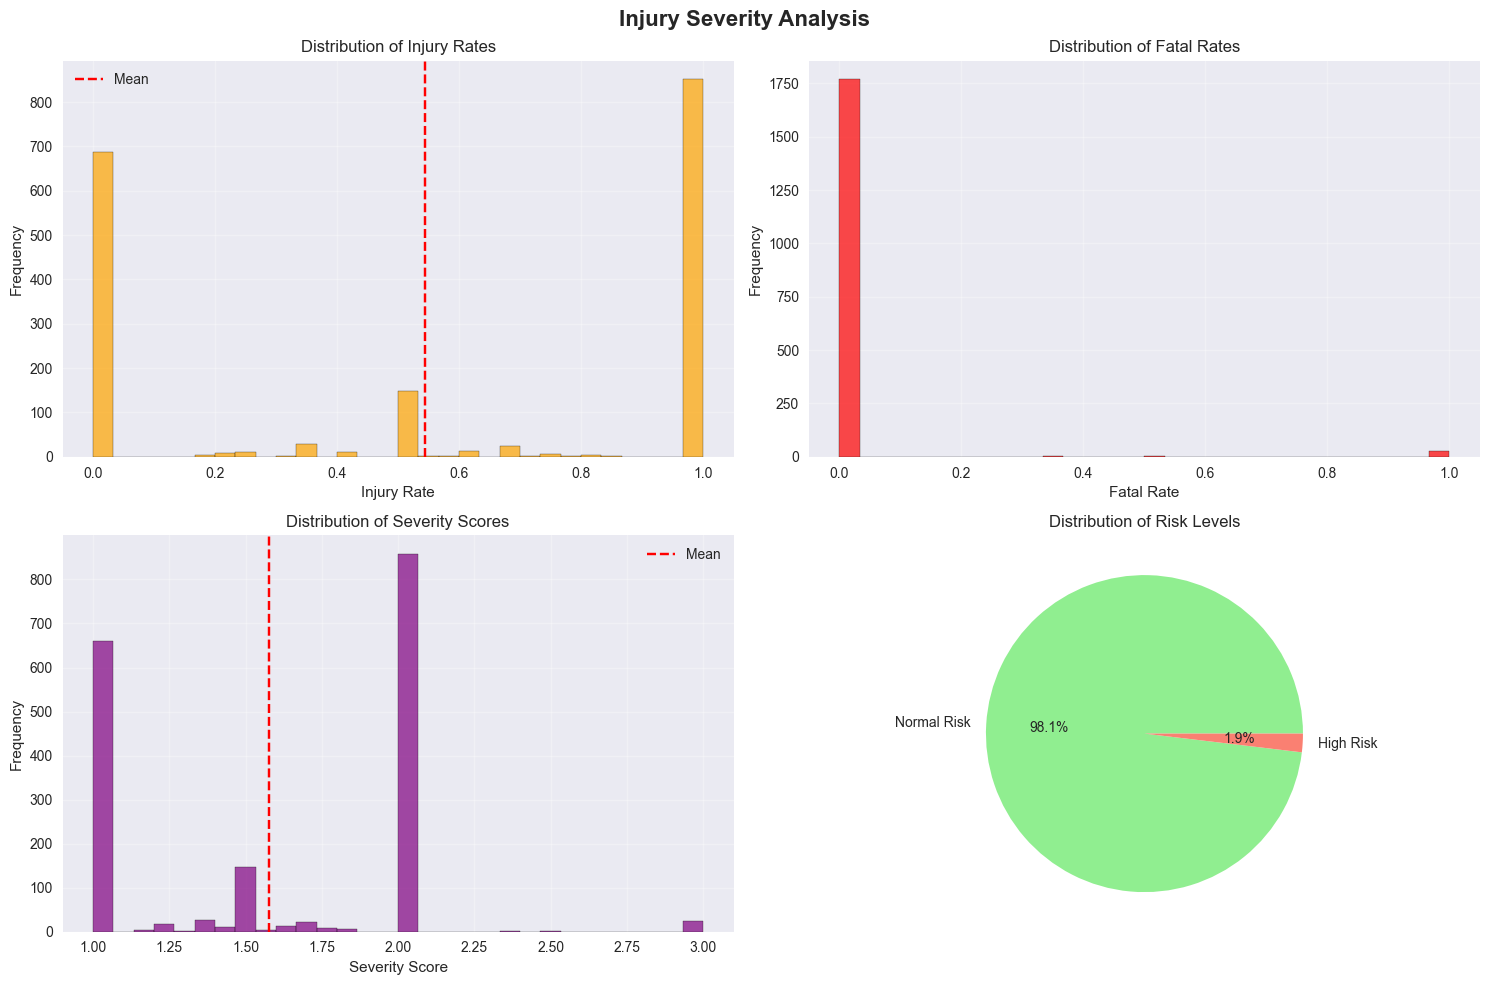

In [27]:
# Visualize injury patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Injury Severity Analysis', fontsize=16, fontweight='bold')

# Injury rate distribution
axes[0,0].hist(injury_data['injury_rate'].dropna(), bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,0].set_xlabel('Injury Rate')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Injury Rates')
axes[0,0].axvline(injury_data['injury_rate'].mean(), color='red', linestyle='--', label='Mean')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Fatal rate distribution
axes[0,1].hist(injury_data['fatal_rate'].dropna(), bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_xlabel('Fatal Rate')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Fatal Rates')
axes[0,1].grid(True, alpha=0.3)

# Severity score distribution
axes[1,0].hist(injury_data['severity_score'].dropna(), bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_xlabel('Severity Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Severity Scores')
axes[1,0].axvline(injury_data['severity_score'].mean(), color='red', linestyle='--', label='Mean')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# High-risk vs normal locations
risk_counts = injury_data['high_risk_location'].value_counts()
axes[1,1].pie(risk_counts.values, labels=['Normal Risk', 'High Risk'], 
             autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
axes[1,1].set_title('Distribution of Risk Levels')

plt.tight_layout()
plot_path4='../presentation/injury_severity.png'
plt.savefig(plot_path4, facecolor=colors['background'])
plt.show()

## Future Hotspot Predictions {#predictions}

Now let's predict future hotspots for 2025 under different weather scenarios.

### Normal Weather Scenario

In [35]:
# Predict future hotspots for normal weather
predictor.predict_future_hotspots(future_year=2025, weather_scenario='normal')

print("\n🎯 Future Hotspot Predictions (Normal Weather 2025):")
normal_predictions = predictor.future_predictions.copy()
display(normal_predictions.head(10))

Predicting future hotspots for 2025...

Future Hotspot Predictions for 2025 (normal weather):
    cluster_id  center_lat  center_lon  prediction_score risk_level
0          117   52.366644    4.884808          0.555177     Medium
5            1   52.303393    4.967976          0.532064     Medium
1          162   52.371939    4.866020          0.514123     Medium
7          167   52.381113    4.842852          0.512767     Medium
18         133   52.340533    4.900128          0.497575     Medium
20         168   52.372929    4.893401          0.496146     Medium
8           12   52.310703    4.960736          0.490121     Medium
30          48   52.340910    4.949180          0.488999     Medium
29          13   52.418119    4.867897          0.488999     Medium
33         156   52.338297    4.841806          0.488415     Medium

🎯 Future Hotspot Predictions (Normal Weather 2025):


,cluster_id,center_lat,center_lon,historical_accidents,base_risk,weather_risk,temporal_weight,injury_risk,prediction_score,risk_level
0,117,52.366644,4.884808,1189,0.708171,0.439695,0.7,0.0,0.555177,Medium
5,1,52.303393,4.967976,404,0.600389,0.439695,0.8,0.0,0.532064,Medium
1,162,52.371939,4.866020,702,0.655536,0.439695,0.6,0.0,0.514123,Medium
7,167,52.381113,4.842852,249,0.552146,0.439695,0.8,0.0,0.512767,Medium
18,133,52.340533,4.900128,170,0.514166,0.439695,0.8,0.0,0.497575,Medium
20,168,52.372929,4.893401,164,0.510595,0.439695,0.8,0.0,0.496146,Medium
8,12,52.310703,4.960736,233,0.545532,0.439695,0.7,0.0,0.490121,Medium
30,48,52.340910,4.949180,137,0.492725,0.439695,0.8,0.0,0.488999,Medium
29,13,52.418119,4.867897,137,0.492725,0.439695,0.8,0.0,0.488999,Medium
33,156,52.338297,4.841806,135,0.491265,0.439695,0.8,0.0,0.488415,Medium


### Harsh Weather Scenario

In [37]:
# Predict future hotspots for harsh weather
predictor.predict_future_hotspots(future_year=2025, weather_scenario='harsh')

print("\n⛈️ Future Hotspot Predictions (Harsh Weather 2025):")
harsh_predictions = predictor.future_predictions.copy()
display(harsh_predictions.head(10))

Predicting future hotspots for 2025...

Future Hotspot Predictions for 2025 (harsh weather):
    cluster_id  center_lat  center_lon  prediction_score risk_level
0          117   52.366644    4.884808          0.591681     Medium
5            1   52.303393    4.967976          0.568568     Medium
1          162   52.371939    4.866020          0.550627     Medium
7          167   52.381113    4.842852          0.549271     Medium
18         133   52.340533    4.900128          0.534079     Medium
20         168   52.372929    4.893401          0.532650     Medium
8           12   52.310703    4.960736          0.526625     Medium
30          48   52.340910    4.949180          0.525503     Medium
29          13   52.418119    4.867897          0.525503     Medium
33         156   52.338297    4.841806          0.524919     Medium

⛈️ Future Hotspot Predictions (Harsh Weather 2025):


,cluster_id,center_lat,center_lon,historical_accidents,base_risk,weather_risk,temporal_weight,injury_risk,prediction_score,risk_level
0,117,52.366644,4.884808,1189,0.708171,0.561375,0.7,0.0,0.591681,Medium
5,1,52.303393,4.967976,404,0.600389,0.561375,0.8,0.0,0.568568,Medium
1,162,52.371939,4.866020,702,0.655536,0.561375,0.6,0.0,0.550627,Medium
7,167,52.381113,4.842852,249,0.552146,0.561375,0.8,0.0,0.549271,Medium
18,133,52.340533,4.900128,170,0.514166,0.561375,0.8,0.0,0.534079,Medium
20,168,52.372929,4.893401,164,0.510595,0.561375,0.8,0.0,0.532650,Medium
8,12,52.310703,4.960736,233,0.545532,0.561375,0.7,0.0,0.526625,Medium
30,48,52.340910,4.949180,137,0.492725,0.561375,0.8,0.0,0.525503,Medium
29,13,52.418119,4.867897,137,0.492725,0.561375,0.8,0.0,0.525503,Medium
33,156,52.338297,4.841806,135,0.491265,0.561375,0.8,0.0,0.524919,Medium


### Mild Weather Scenario

In [65]:
# Predict future hotspots for mild weather
predictor.predict_future_hotspots(future_year=2025, weather_scenario='mild')

print("\n☀️ Future Hotspot Predictions (Mild Weather 2025):")
mild_predictions = predictor.future_predictions.copy()
display(mild_predictions.head(10))

Predicting future hotspots for 2025...

Future Hotspot Predictions for 2025 (mild weather):
    cluster_id  center_lat  center_lon  prediction_score risk_level
0          117   52.366644    4.884808          0.529748     Medium
5            1   52.303393    4.967976          0.506635     Medium
1          162   52.371939    4.866020          0.488694     Medium
7          167   52.381113    4.842852          0.487338     Medium
18         133   52.340533    4.900128          0.472146     Medium
20         168   52.372929    4.893401          0.470717     Medium
8           12   52.310703    4.960736          0.464692     Medium
30          48   52.340910    4.949180          0.463570     Medium
29          13   52.418119    4.867897          0.463570     Medium
33         156   52.338297    4.841806          0.462986     Medium

☀️ Future Hotspot Predictions (Mild Weather 2025):


,cluster_id,center_lat,center_lon,historical_accidents,base_risk,weather_risk,temporal_weight,injury_risk,prediction_score,risk_level
0,117,52.366644,4.884808,1189,0.708171,0.354932,0.7,0.0,0.529748,Medium
5,1,52.303393,4.967976,404,0.600389,0.354932,0.8,0.0,0.506635,Medium
1,162,52.371939,4.866020,702,0.655536,0.354932,0.6,0.0,0.488694,Medium
7,167,52.381113,4.842852,249,0.552146,0.354932,0.8,0.0,0.487338,Medium
18,133,52.340533,4.900128,170,0.514166,0.354932,0.8,0.0,0.472146,Medium
20,168,52.372929,4.893401,164,0.510595,0.354932,0.8,0.0,0.470717,Medium
8,12,52.310703,4.960736,233,0.545532,0.354932,0.7,0.0,0.464692,Medium
30,48,52.340910,4.949180,137,0.492725,0.354932,0.8,0.0,0.463570,Medium
29,13,52.418119,4.867897,137,0.492725,0.354932,0.8,0.0,0.463570,Medium
33,156,52.338297,4.841806,135,0.491265,0.354932,0.8,0.0,0.462986,Medium


### Compare Weather Scenarios

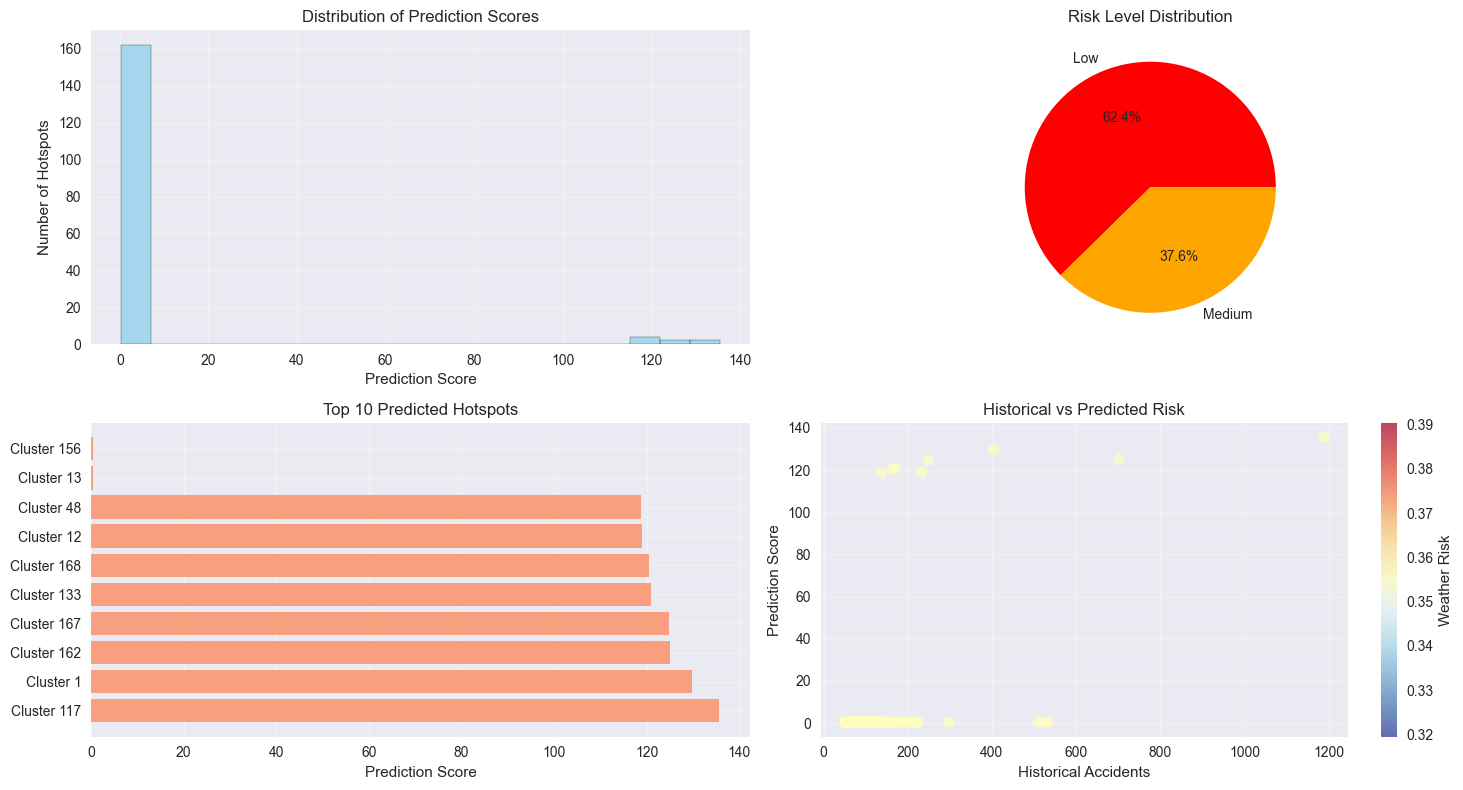

In [86]:
# Compare prediction scores across weather scenarios
plt.figure(figsize=(15, 8))

# Plot prediction score distribution
plt.subplot(2, 2, 1)
plt.hist(predictor.future_predictions['prediction_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Scores')
plt.xlabel('Prediction Score')
plt.ylabel('Number of Hotspots')
plt.grid(True, alpha=0.3)

# Risk level distribution
plt.subplot(2, 2, 2)
risk_counts = predictor.future_predictions['risk_level'].value_counts()
plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
        colors=['red', 'orange', 'yellow'])
plt.title('Risk Level Distribution')

# Top 10 hotspots by prediction score
plt.subplot(2, 2, 3)
top_10 = predictor.future_predictions.head(10)
plt.barh(range(len(top_10)), top_10['prediction_score'], color='coral', alpha=0.7)
plt.yticks(range(len(top_10)), [f'Cluster {cid}' for cid in top_10['cluster_id']])
plt.xlabel('Prediction Score')
plt.title('Top 10 Predicted Hotspots')
plt.grid(True, alpha=0.3)

# Scatter plot: Historical vs Predicted Risk
plt.subplot(2, 2, 4)
plt.scatter(predictor.future_predictions['historical_accidents'], 
           predictor.future_predictions['prediction_score'],
           c=predictor.future_predictions['weather_risk'], 
           cmap='RdYlBu_r', s=60, alpha=0.7)
plt.xlabel('Historical Accidents')
plt.ylabel('Prediction Score')
plt.title('Historical vs Predicted Risk')
plt.colorbar(label='Weather Risk')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path5='../presentation/prediction_score.png'
plt.savefig(plot_path5, facecolor=colors['background'])
plt.show()

## Interactive Visualizations {#visualizations}

Let's create interactive maps to visualize the predicted hotspots.

In [77]:
# Create prediction maps for different scenarios
print(" Creating interactive maps...")

# Normal weather map
predictor.predict_future_hotspots(future_year=2025, weather_scenario='normal')
predictor.create_prediction_map('../presentation/future_hotspots_normal_2025.html')

# Harsh weather map
predictor.predict_future_hotspots(future_year=2025, weather_scenario='harsh')
predictor.create_prediction_map('../presentation/future_hotspots_harsh_2025.html')

# Mild weather map
predictor.predict_future_hotspots(future_year=2025, weather_scenario='mild')
predictor.create_prediction_map('../presentation/future_hotspots_mild_2025.html')

print(" Interactive maps created successfully!")
print(" Files saved:")
print("   - future_hotspots_normal_2025.html")
print("   - future_hotspots_harsh_2025.html")
print("   - future_hotspots_mild_2025.html")

 Creating interactive maps...
Predicting future hotspots for 2025...

Future Hotspot Predictions for 2025 (normal weather):
    cluster_id  center_lat  center_lon  prediction_score risk_level
0          117   52.366644    4.884808          0.555177     Medium
5            1   52.303393    4.967976          0.532064     Medium
1          162   52.371939    4.866020          0.514123     Medium
7          167   52.381113    4.842852          0.512767     Medium
18         133   52.340533    4.900128          0.497575     Medium
20         168   52.372929    4.893401          0.496146     Medium
8           12   52.310703    4.960736          0.490121     Medium
30          48   52.340910    4.949180          0.488999     Medium
29          13   52.418119    4.867897          0.488999     Medium
33         156   52.338297    4.841806          0.488415     Medium
Creating prediction map...
Map saved as ../presentation/future_hotspots_normal_2025.html
Predicting future hotspots for 2025...


### Display Map in Notebook

In [79]:
# Create a simplified map for display in notebook
center_lat = predictor.coord_data_clean['latitude'].mean()
center_lon = predictor.coord_data_clean['longitude'].mean()

# Create map centered on Amsterdam
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles='OpenStreetMap'
)

# Add top 20 predicted hotspots
risk_colors = {'High': 'red', 'Medium': 'orange', 'Low': 'yellow'}

for _, pred in predictor.future_predictions.head(20).iterrows():
    color = risk_colors[pred['risk_level']]
    
    folium.CircleMarker(
        location=[pred['center_lat'], pred['center_lon']],
        radius=max(5, pred['prediction_score'] * 15),
        popup=f"""
        <b>Predicted Hotspot</b><br>
        Cluster ID: {pred['cluster_id']}<br>
        Risk Level: {pred['risk_level']}<br>
        Prediction Score: {pred['prediction_score']:.3f}<br>
        Historical Accidents: {pred['historical_accidents']}
        """,
        color=color,
        fillColor=color,
        fillOpacity=0.7,
        weight=2
    ).add_to(m)

# Display the map
m

## Results Summary {#summary}

Let's generate a comprehensive report of our analysis.

In [74]:
# Generate comprehensive report
report = predictor.generate_report()

print(" Analysis Report Generated!")
print(" Report saved as: hotspot_prediction_report.txt")

Generating prediction report...

        BIKE ACCIDENT HOTSPOT PREDICTION REPORT
        
        ANALYSIS SUMMARY:
        - Total accidents analyzed: 29,763
        - Hotspot clusters identified: 170
        - Weather years analyzed: 7
        - Injury locations analyzed: 1,803
        
        TOP 5 PREDICTED FUTURE HOTSPOTS:
        
        1. Cluster 117 - Medium Risk
           Location: (52.3666, 4.8848)
           Prediction Score: 0.530
           Historical Accidents: 1189
           Weather Risk Factor: 0.355
           Injury Risk Factor: 0.000
        
        2. Cluster 1 - Medium Risk
           Location: (52.3034, 4.9680)
           Prediction Score: 0.507
           Historical Accidents: 404
           Weather Risk Factor: 0.355
           Injury Risk Factor: 0.000
        
        3. Cluster 162 - Medium Risk
           Location: (52.3719, 4.8660)
           Prediction Score: 0.489
           Historical Accidents: 702
           Weather Risk Factor: 0.355
           

### Key Findings Summary

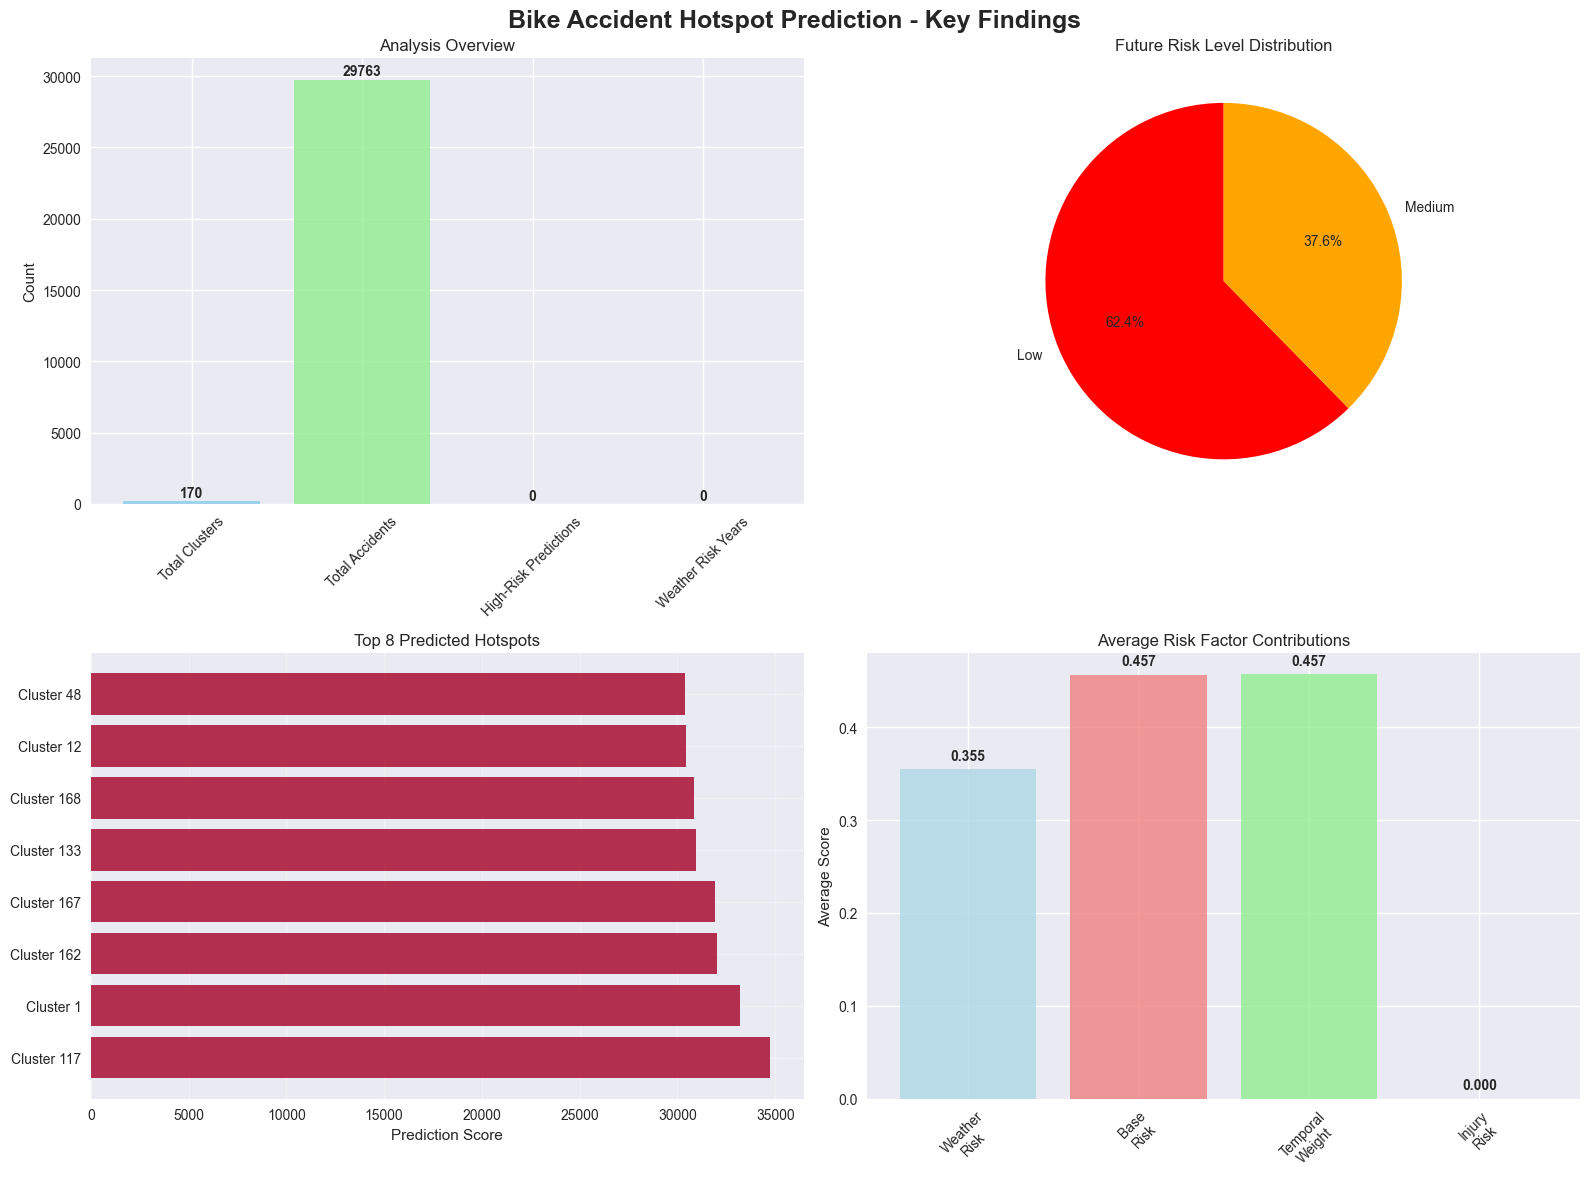


🎯 Key Insights:
• Identified 170 distinct accident hotspots
• 0 locations predicted as high-risk for 2025
• Weather conditions contribute an average of 0.355 to risk scores
• 34 locations identified with high injury severity
• Top predicted hotspot has a score of 34717.562


In [90]:
# Create a summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bike Accident Hotspot Prediction - Key Findings', fontsize=18, fontweight='bold')

# 1. Cluster analysis summary
cluster_stats = {
    'Total Clusters': len(predictor.hotspot_clusters),
    'Total Accidents': len(predictor.coord_data_clean),
    'High-Risk Predictions': len(predictor.future_predictions[predictor.future_predictions['risk_level'] == 'High']),
    'Weather Risk Years': predictor.weather_analysis['high_risk_weather'].sum()
}

axes[0,0].bar(cluster_stats.keys(), cluster_stats.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange'], alpha=0.8)
axes[0,0].set_title('Analysis Overview')
axes[0,0].set_ylabel('Count')
for i, (k, v) in enumerate(cluster_stats.items()):
    axes[0,0].text(i, v + max(cluster_stats.values()) * 0.01, str(v), ha='center', fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Risk level distribution
risk_dist = predictor.future_predictions['risk_level'].value_counts()
axes[0,1].pie(risk_dist.values, labels=risk_dist.index, autopct='%1.1f%%', 
              colors=['red', 'orange', 'yellow'], startangle=90)
axes[0,1].set_title('Future Risk Level Distribution')

# 3. Top hotspots by prediction score
top_hotspots = predictor.future_predictions.head(8)
axes[1,0].barh(range(len(top_hotspots)), top_hotspots['prediction_score'], 
               color=plt.cm.RdYlBu_r(top_hotspots['prediction_score']), alpha=0.8)
axes[1,0].set_yticks(range(len(top_hotspots)))
axes[1,0].set_yticklabels([f'Cluster {cid}' for cid in top_hotspots['cluster_id']])
axes[1,0].set_xlabel('Prediction Score')
axes[1,0].set_title('Top 8 Predicted Hotspots')
axes[1,0].grid(True, alpha=0.3)

# 4. Weather impact analysis
weather_impact = {
    'Weather\nRisk': predictor.future_predictions['weather_risk'].mean(),
    'Base\nRisk': predictor.future_predictions['base_risk'].mean(),
    'Temporal\nWeight': predictor.future_predictions['temporal_weight'].mean(),
    'Injury\nRisk': predictor.future_predictions['injury_risk'].mean()
}

axes[1,1].bar(weather_impact.keys(), weather_impact.values(), 
              color=['lightblue', 'lightcoral', 'lightgreen', 'plum'], alpha=0.8)
axes[1,1].set_title('Average Risk Factor Contributions')
axes[1,1].set_ylabel('Average Score')
axes[1,1].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(weather_impact.items()):
    axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plot_path6='../presentation/acc_hotspot_prediction_finding.png'
plt.savefig(plot_path6, facecolor=colors['background'])
plt.show()

print("\n🎯 Key Insights:")
print(f"• Identified {len(predictor.hotspot_clusters)} distinct accident hotspots")
print(f"• {len(predictor.future_predictions[predictor.future_predictions['risk_level'] == 'High'])} locations predicted as high-risk for 2025")
print(f"• Weather conditions contribute an average of {predictor.future_predictions['weather_risk'].mean():.3f} to risk scores")
print(f"• {predictor.injury_analysis['high_risk_location'].sum()} locations identified with high injury severity")
print(f"• Top predicted hotspot has a score of {predictor.future_predictions['prediction_score'].max():.3f}")

## Conclusion

This analysis successfully demonstrates the use of machine learning clustering techniques to predict future bike accident hotspots. The `BikeAccidentHotspotPredictor` class provides a comprehensive framework for:

1. **Data Integration**: Combining spatial, temporal, and environmental data
2. **Hotspot Identification**: Using HDBSCAN clustering to find accident concentration areas
3. **Risk Assessment**: Incorporating weather patterns and injury severity data
4. **Future Prediction**: Modeling different weather scenarios for 2025
5. **Visualization**: Creating interactive maps and comprehensive reports

### Recommendations for Implementation:

- **Focus resources** on the highest-scoring predicted hotspots
- **Monitor weather conditions** and adjust safety measures accordingly
- **Implement targeted interventions** at locations with high injury severity
- **Regular model updates** with new accident data to improve predictions

### Files Generated:
- Interactive maps for different weather scenarios
- Comprehensive prediction report
- Analysis visualizations and statistics

This notebook provides a complete workflow for bike accident hotspot prediction that can be adapted for other cities and transportation safety applications.